In [71]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
import matplotlib.pyplot as plt
from numpy import  *
import pandas as pd

base = pd.read_csv('archive/Variant I.csv')
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)
base = base.to_numpy()

# class prior 
prior = sum(base[:,0])/len(base)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)

class prior for positive: 0.011029
class prior for negative: 0.988971


ROC space is $[0,1]^2$, where the x axis is False Positive Rate (FPR) and y axis is True Positive Rate (TPR).

Recall, $\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ and $\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$.

ROC Heaven is the top-left corner of the ROC space, where TPR=1 and FPR=0. ROC Hell is the bottom-right corner of the ROC space, where TPR=0 and FPR=1.

Text(0, 0.5, 'True Positive Rate')

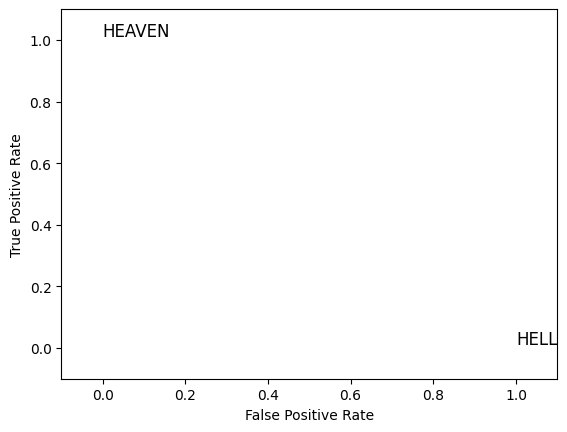

In [72]:
def TPR(pred, label):
    TP = sum((pred==1) & (label==1))
    FN = sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = sum((pred==1) & (label==0))
    TN = sum((pred==0) & (label==0))
    return FP/(FP+TN)

# text on the plot
plt.text(1, 0, 'HELL', fontsize=12, verticalalignment='bottom')
plt.text(0, 1, 'HEAVEN', fontsize=12, verticalalignment='bottom')

# visualize the ROC space
plt.xlim(-.1,1.1); plt.ylim(-.1,1.1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Let us see some baseline classifier and how they perform in the ROC space.

Text(0, 0.5, 'True Positive Rate')

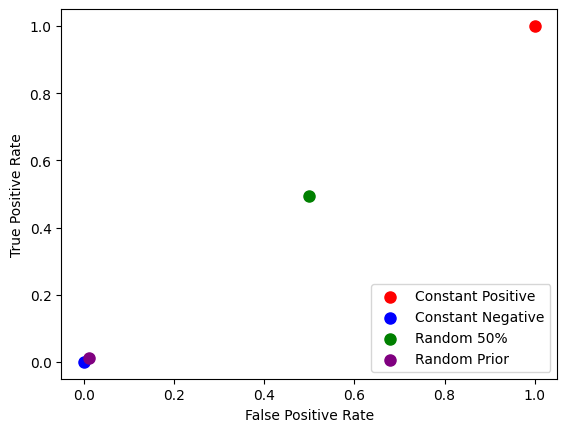

In [73]:
label = base[:,0]

# see how a constant positive classifier will perform 
TPR_constpos = TPR(ones(len(base)), label)
FPR_constpos = FPR(ones(len(base)), label)

# see how a constant negative classifier will perform
TPR_constneg = TPR(zeros(len(base)), label)
FPR_constneg = FPR(zeros(len(base)), label)

plt.scatter(FPR_constpos, TPR_constpos, 64, color = 'red', marker = 'o', label = 'Constant Positive')
plt.scatter(FPR_constneg, TPR_constneg, 64, color = 'blue', marker = 'o', label = 'Constant Negative')

# a random classifier, which will pick positive 50 percent of the time
pred = random.rand(len(base)) > .5

TPR_rand = TPR(pred, label)
FPR_rand = FPR(pred, label)

plt.scatter(FPR_rand, TPR_rand, 64, color = 'green', marker = 'o', label = 'Random 50%')

# a random classifier, which will pick positive according to the class prior
pred = random.rand(len(base)) < prior
TPR_rand2 = TPR(pred, label)
FPR_rand2 = FPR(pred, label)
plt.scatter(FPR_rand2, TPR_rand2, 64, color = 'purple', marker = 'o', label = 'Random Prior')
plt.legend(loc = 'lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Let us train a classifier (logistic regression with linear model) on the dataset. 

In [74]:
def roc(pred, label):
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])

# train a logistic regression using sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = base[:,1:]
y = base[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# not weighted
clf0 = LogisticRegression(random_state=0, max_iter = 100).fit(X_train, y_train, sample_weight = None)
# weight the samples according to the class prior
weights = y_train*(1-prior) + (1-y_train)*prior
clf1 = LogisticRegression(random_state=0, max_iter = 100).fit(X_train, y_train, sample_weight = weights)

/home/song/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/song/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Text(0, 0.5, 'True Positive Rate')

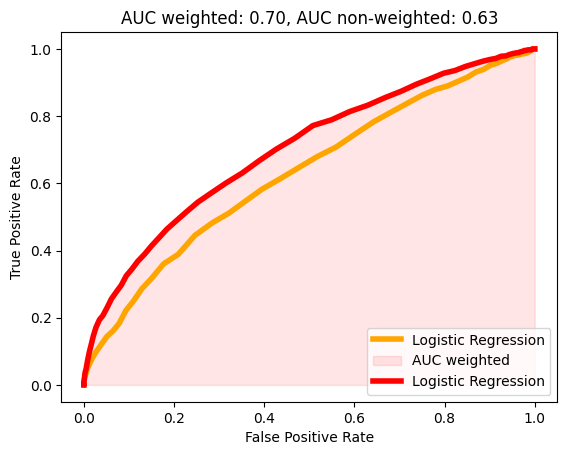

In [75]:
y_score0 = clf0.decision_function(X_test)
fpr0, tpr0 = roc(y_score0, y_test)
y_score1 = clf1.decision_function(X_test)
fpr1, tpr1 = roc(y_score1, y_test)

plt.plot(fpr0, tpr0, color = 'orange', label = 'Logistic Regression', linewidth = 4)

# plot the histogram under the curve
plt.fill_between(fpr1, tpr1, color = 'red', alpha = .1, label = 'AUC weighted')
plt.plot(fpr1, tpr1, color = 'red', label = 'Logistic Regression', linewidth = 4)
plt.title('AUC weighted: %0.2f, AUC non-weighted: %0.2f' % (AUC(fpr1, tpr1), AUC(fpr0, tpr0)))
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Slightly better than baseline classifiers. Now try AUC maximization

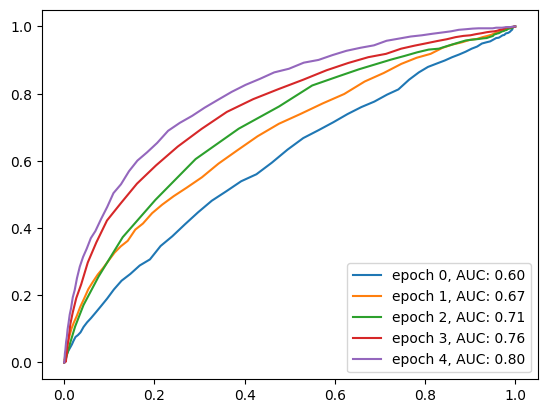

In [76]:
import pylab as pl
from IPython import display

# Let us maximize the AUC
import torch # bring out the big gun

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

# same linear model
class NN(torch.nn.Module):
    def __init__(self, d):
        super(NN, self).__init__()
        self.fc = torch.nn.Linear(d, 1)
        
    def forward(self, x):
        return self.fc(x)

X_tr = torch.tensor(X_train, dtype = torch.float32)
y_tr = torch.tensor(y_train, dtype = torch.float32)
X_te = torch.tensor(X_test, dtype = torch.float32)
y_te = torch.tensor(y_test, dtype = torch.float32)

dataset = torch.utils.data.TensorDataset(X_tr, y_tr)
trainload = torch.utils.data.DataLoader(dataset, batch_size = 10000, shuffle = True)

model = NN(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(5):
    for x, y in trainload:
        optimizer.zero_grad()
        pred = model(x)
        loss = aucloss(pred, y)
        
        loss.backward()
        optimizer.step()
    
    pred_te = model(X_te).detach().numpy()[:,0]

    fpr, tpr = roc(pred_te, y_test)
    auc = AUC(fpr, tpr)
    
    pl.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    pl.legend(loc = 'lower right')
    display.display(pl.gcf())
    display.clear_output(wait=True)
